<a href="https://colab.research.google.com/github/DakshiW/project_group_i/blob/main/Fiona/unswprojectv10%20with%20charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone data from GitHub

In [1]:
# Clone the ZZSC9020 project repository from GitHub
!git clone https://github.com/UNSW-ZZSC9020-2023H2/project.git

Cloning into 'project'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 1), reused 1 (delta 1), pack-reused 21
Unpacking objects: 100% (25/25), 121.23 MiB | 15.73 MiB/s, done.


In [2]:
# Create a data folder
!mkdir -p data

In [3]:
# Joint forecastdemand_nsw files into a single file. 
!cat project/data/forecastdemand_nsw.csv.zip.part* > data/forecastdemand_nsw.csv.zip

In [4]:
# Unzip the data files into the data folder
!unzip data/forecastdemand_nsw.csv.zip -d data
!unzip project/data/temperature_nsw.csv.zip -d data
!unzip project/data/totaldemand_nsw.csv.zip -d data

Archive:  data/forecastdemand_nsw.csv.zip
  inflating: data/forecastdemand_nsw.csv  
  inflating: data/__MACOSX/._forecastdemand_nsw.csv  
Archive:  project/data/temperature_nsw.csv.zip
  inflating: data/temperature_nsw.csv  
  inflating: data/__MACOSX/._temperature_nsw.csv  
Archive:  project/data/totaldemand_nsw.csv.zip
  inflating: data/totaldemand_nsw.csv  
  inflating: data/__MACOSX/._totaldemand_nsw.csv  


In [5]:
# Remove forecastdemand_nsw.csv.zip
!rm data/forecastdemand_nsw.csv.zip

# Time Series Model

## Import Libraries

In [472]:
# Others
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# for data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae
from datetime import date, timedelta
from calendar import monthrange 

# for time series model
!pip install pmdarima
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for performance metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import math
from sklearn.metrics import mean_squared_error

# extract execution time
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7.15 s (started: 2023-04-11 02:53:01 +00:00)


## Data Preprocessing

In [473]:
# Load the data
totaldemand = pd.read_csv('data/totaldemand_nsw.csv',index_col='DATETIME').sort_index()
temperature = pd.read_csv('data/temperature_nsw.csv',index_col='DATETIME').sort_index()
forecastdemand = pd.read_csv('data/forecastdemand_nsw.csv',index_col='DATETIME').sort_index()


time: 11.3 s (started: 2023-04-11 02:53:08 +00:00)


In [474]:
# Check for NaN values
print(f'NaN values in totaldemand= {totaldemand.isna().sum().sum()}')
print(f'NaN values in temperature= {temperature.isna().sum().sum()}')
print(f'NaN values in forecastdemand= {forecastdemand.isna().sum().sum()}')

NaN values in totaldemand= 0
NaN values in temperature= 0
NaN values in forecastdemand= 0
time: 2.99 s (started: 2023-04-11 02:53:20 +00:00)


In [475]:
# Check for zero or negative values
print(f'Zero or negative values in totaldemand= {((totaldemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in temperature= {((temperature.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in forecastdemand= {((forecastdemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')

Zero or negative values in totaldemand= 0
Zero or negative values in temperature= 36
Zero or negative values in forecastdemand= 0
time: 175 ms (started: 2023-04-11 02:53:23 +00:00)


In [476]:
# Explore extreme temperature values
temperature.loc[temperature['TEMPERATURE']<=0]

,LOCATION,TEMPERATURE
DATETIME,,
2010-03-23 15:00:00,94766.0,-9999.0
2010-04-27 10:00:00,94766.0,-9999.0
2010-05-01 06:00:00,94766.0,-9999.0
2010-06-29 04:30:00,94766.0,-0.2
2010-06-29 05:30:00,94766.0,-0.1
2010-06-29 06:30:00,94766.0,-0.3
2010-06-30 04:30:00,94766.0,-0.3
2010-06-30 05:00:00,94766.0,-0.5
2010-06-30 05:30:00,94766.0,-0.4


time: 10.9 ms (started: 2023-04-11 02:53:23 +00:00)


In [477]:
# Remove rows with unreasonable values
temperature = temperature.loc[temperature['TEMPERATURE']!=-9999]

time: 6.51 ms (started: 2023-04-11 02:53:23 +00:00)


In [478]:
# Convert relevant columns to datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
totaldemand.index = pd.to_datetime(totaldemand.index, format=datetime_format)
temperature.index = pd.to_datetime(temperature.index, format=datetime_format)
forecastdemand.index = pd.to_datetime(forecastdemand.index, format=datetime_format)
forecastdemand['LASTCHANGED'] = pd.to_datetime(forecastdemand['LASTCHANGED'], format=datetime_format)

time: 3.14 s (started: 2023-04-11 02:53:23 +00:00)


In [479]:
# Drop unwanted columns
totaldemand.drop(['REGIONID'],axis=1,inplace=True)
temperature.drop(['LOCATION'],axis=1,inplace=True)
forecastdemand.drop(['REGIONID','PREDISPATCHSEQNO','PERIODID'],axis=1,inplace=True)

time: 123 ms (started: 2023-04-11 02:53:26 +00:00)


In [480]:
# Create the dataframe for modelling
df = totaldemand.resample('5T').median().interpolate() # resample demand to 5-min bins and fill NaN by linear interpolation
df = df.join(temperature).sort_index().interpolate() # join temperature data and fill NaN by linear interpolation
print(f'Check NaN in df: {df.isna().sum().sum()}')
print(df)

Check NaN in df: 0
                     TOTALDEMAND  TEMPERATURE
DATETIME                                     
2010-01-01 00:00:00      7997.41    23.100000
2010-01-01 00:05:00      7946.51    23.066667
2010-01-01 00:10:00      7921.55    23.033333
2010-01-01 00:15:00      7837.84    23.000000
2010-01-01 00:20:00      7781.11    22.966667
...                          ...          ...
2022-07-31 23:40:00      8180.34    12.500000
2022-07-31 23:45:00      8237.50    12.400000
2022-07-31 23:50:00      8109.83    12.300000
2022-07-31 23:55:00      8044.52    12.200000
2022-08-01 00:00:00      8027.28    12.100000

[1323361 rows x 2 columns]
time: 368 ms (started: 2023-04-11 02:53:26 +00:00)


In [481]:
# Create a dataframe for comaprison between actual and forecast demands
df_forecast = pd.merge(forecastdemand,totaldemand,left_index=True,right_index=True)
df_forecast['DURATION'] = (df_forecast.index - df_forecast['LASTCHANGED']).astype('timedelta64[h]').astype('int')
df_forecast['ERROR'] = abs(df_forecast['FORECASTDEMAND'] - df_forecast['TOTALDEMAND'])/df_forecast['TOTALDEMAND']*100
df_forecast.drop(['FORECASTDEMAND','TOTALDEMAND','LASTCHANGED'],axis=1,inplace=True)

time: 2.28 s (started: 2023-04-11 02:53:27 +00:00)


In [482]:
# Set parameters for different prediction time frames

# Short term prediction: 1 day into the future
window_short = 'D'

# Medium term prediction: 1 week into the future
window_medium = 'W'

# Long term prediction: 1 month into the future
window_long = 'M'

time: 547 µs (started: 2023-04-11 02:53:29 +00:00)


In [483]:
# Resample df based on the windows to fit time series model
# Note: demand is divided by 1000 to convert to GW (gigawatts)

# Short term prediction:
ts_short = df.resample(window_short).agg({'TOTALDEMAND':lambda x:x.sum()/1000,'TEMPERATURE':'median'})
ts_short['DATE']= ts_short.index.date
ts_short['Month_Number']= ts_short.index.month
ts_short = ts_short.iloc[:-1] # remove the last value after resampling to 1D

# Medium term prediction:
ts_medium = df.resample(window_medium).agg({'TOTALDEMAND':lambda x:x.sum()/1000,'TEMPERATURE':'median'})
ts_medium['DATE'] = ts_medium.index.date
ts_medium['Month_Number']= ts_medium.index.month
ts_medium = ts_medium.iloc[1:-1] # remove the first and last value after resampling to 1W

# Long term prediction:
ts_long = df.resample(window_long).agg({'TOTALDEMAND':lambda x:x.sum()/1000,'TEMPERATURE':'median'})
ts_long['DATE'] = ts_long.index.date
ts_long['Month_Number']= ts_long.index.month
ts_long = ts_long.iloc[:-1] # remove last value after resampling to 1M

time: 736 ms (started: 2023-04-11 02:53:29 +00:00)


## Exploratory Data Analysis (EDA)

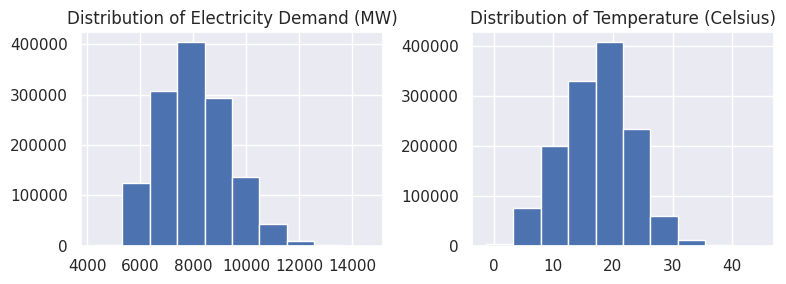

<Figure size 640x480 with 0 Axes>

time: 610 ms (started: 2023-04-11 02:53:30 +00:00)


In [484]:
# Plot distributions of totaldemand and temperature
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
ax1.hist(df['TOTALDEMAND'])
ax1.title.set_text('Distribution of Electricity Demand (MW)')
ax2.hist(df['TEMPERATURE'])
ax2.title.set_text('Distribution of Temperature (Celsius)')
plt.tight_layout()
plt.show()
plt.clf()

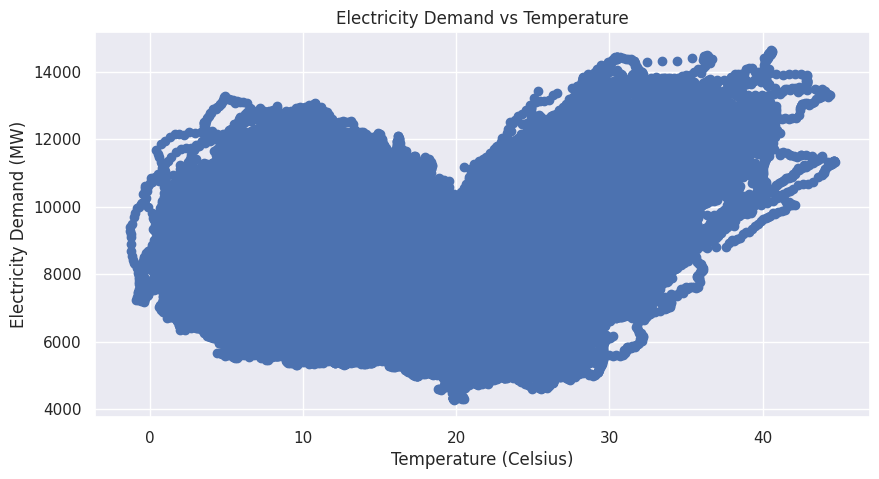

<function matplotlib.pyplot.clf()>

time: 2.84 s (started: 2023-04-11 02:53:30 +00:00)


In [485]:
# Plot totaldemand vs temperature
plt.figure(figsize=[10, 5])
plt.scatter(df['TEMPERATURE'], df['TOTALDEMAND'])
plt.ylabel('Electricity Demand (MW)')
plt.xlabel('Temperature (Celsius)')
plt.title('Electricity Demand vs Temperature')
plt.show()
plt.clf

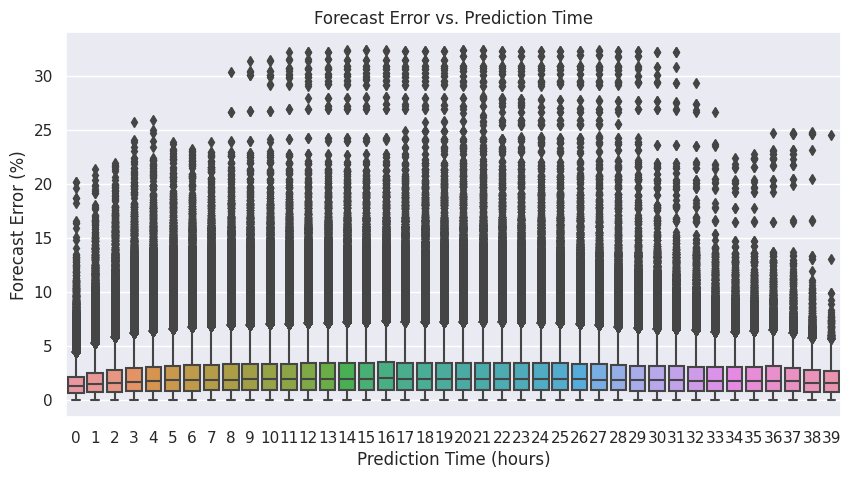

<Figure size 640x480 with 0 Axes>

time: 3.44 s (started: 2023-04-11 02:53:33 +00:00)


In [486]:
# Plot forecast error vs prediction time
plt.figure(figsize=[10, 5])
sns.boxplot(x='DURATION', y='ERROR', data=df_forecast).set(
    title='Forecast Error vs. Prediction Time',
    xlabel = 'Prediction Time (hours)',
    ylabel = 'Forecast Error (%)'
    )
plt.show()
plt.clf()

## Key findings from EDA
*   Right-skewed distribution for electricity demand data
*   Normal distribution for temperature data
*   Non-linear (U shape) relationship between electricity demand and temperature
*   Electricity demand is the lowest around 20 degree Celsius
*   Electricity demand increases at a higher rate under (i.e. more sensitive to) extreme hot weather
*   The longest prediction time for forecast demand is around 39 hours ahead of actual demand
*   Prediction tends to be more accurate within 2 hours before actual demand
*   Boxplot shows many outliers of forecast errors which extend to over 30%, indicating poor prediction performance of current model
*   Overall, predictions made by the current model is very short term and not reliable, hence not useful for energy planning

## Time Series Model

### Identify seasonality and trend

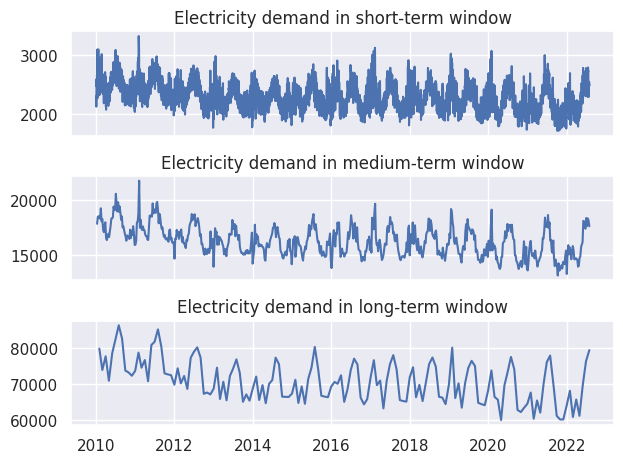

<Figure size 640x480 with 0 Axes>

time: 1.21 s (started: 2023-04-11 02:53:36 +00:00)


In [487]:
# Plot totaldemand vs time for different prediction time frames
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax1.plot(ts_short['TOTALDEMAND'])
ax1.title.set_text('Electricity demand in short-term window')
ax2.plot(ts_medium['TOTALDEMAND'])
ax2.title.set_text('Electricity demand in medium-term window')
ax3.plot(ts_long['TOTALDEMAND'])
ax3.title.set_text('Electricity demand in long-term window')
plt.tight_layout()
plt.show()
plt.clf()

### Findings on seasonality and trend:
*  Electricity demand shows seasonality patterns in all windows
*  Electricity demand has no significant trend (upward or downward) in all windows

### Augmented Dickey-Fuller (ADF) test for stationarity

In [488]:
# Define ADF test function
def adf_test(series,title='',maxlag=None,autolag='AIC'):
    """
    series: data series
    title: add optional title
    maxlag: {None, int}, default value of 12*(nobs/100)^{1/4} 
      is used when None
    autolag: {“AIC” (default), “BIC”, “t-stat”, None}, 
      number of included lags is set to maxlag when None
    Hypothesis test:
    Ho: Data is non-stationary
    H1: Data is stationary
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),maxlag=maxlag,autolag=autolag) 
      # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string()) # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

time: 685 µs (started: 2023-04-11 02:53:38 +00:00)


In [489]:
# ADF test - short term 
adf_test(ts_short['TOTALDEMAND'],title='Demand (Short-term)')

Augmented Dickey-Fuller Test: Demand (Short-term)
ADF test statistic     -6.116561e+00
p-value                 9.064983e-08
# lags used             3.000000e+01
# observations          4.564000e+03
critical value (1%)    -3.431784e+00
critical value (5%)    -2.862173e+00
critical value (10%)   -2.567107e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
time: 203 ms (started: 2023-04-11 02:53:38 +00:00)


In [490]:
# ADF test - medium term
adf_test(ts_medium['TOTALDEMAND'],title='Demand (Medium-term)')

Augmented Dickey-Fuller Test: Demand (Medium-term)
ADF test statistic       -4.078956
p-value                   0.001049
# lags used              15.000000
# observations          640.000000
critical value (1%)      -3.440609
critical value (5%)      -2.866067
critical value (10%)     -2.569181
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
time: 32.1 ms (started: 2023-04-11 02:53:38 +00:00)


In [491]:
# ADF test - long term
adf_test(ts_long['TOTALDEMAND'],title='Demand (Long-term)')

Augmented Dickey-Fuller Test: Demand (Long-term)
ADF test statistic       -2.007299
p-value                   0.283382
# lags used              12.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
time: 16.7 ms (started: 2023-04-11 02:53:38 +00:00)


In [492]:
# Apply differencing to long term demand
ts_long_demand_diff = ts_long['TOTALDEMAND'].diff().dropna()

time: 899 µs (started: 2023-04-11 02:53:38 +00:00)


In [493]:
# Re-confirm stationarity by performing ADF test again
adf_test(ts_long_demand_diff,title='Demand (Long-term)')

Augmented Dickey-Fuller Test: Demand (Long-term)
ADF test statistic     -6.415848e+00
p-value                 1.842183e-08
# lags used             1.100000e+01
# observations          1.380000e+02
critical value (1%)    -3.478648e+00
critical value (5%)    -2.882722e+00
critical value (10%)   -2.578065e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
time: 17.4 ms (started: 2023-04-11 02:53:38 +00:00)


### Discussion on ADF test results:
*   ADF tests on demand data confirms stationarity for short term and medium term, but not for long term
*   First-order differencing has been applied to long term demand data, and subsequent ADF test confirms stationarity 
*   The assumption of stationarity for time series model is met

## SARIMA 

### Optimal parameters

In [494]:
# Find short-term optimal parameters
# ADF # lags used value as m
# sarima_short_optimal = auto_arima(ts_short['TOTALDEMAND']['2019-01-01':'2022-07-31'],seasonal=True,m=30,suppress_warnings=True)
# m=7 as weekly seasonality is assumed on daily data 
# sarima_short_optimal = auto_arima(ts_short['TOTALDEMAND']['2019-01-01':'2022-07-31'],seasonal=True,m=7,suppress_warnings=True)

# print('Optimal order (short term demand):', sarima_short_optimal.order)
# print('Optimal seasonal_order (short term demand):', sarima_short_optimal.seasonal_order)

time: 227 µs (started: 2023-04-11 02:53:38 +00:00)


In [495]:
# Find medium-term optimal parameters
# ADF # lags used value as m
# sarima_medium_optimal = auto_arima(ts_medium['TOTALDEMAND'],seasonal=True,m=15,suppress_warnings=True)
# m=52 as monthly seasonality is assumed on weekly data
# #sarima_medium_optimal = auto_arima(ts_medium['TOTALDEMAND'],seasonal=True,m=52,suppress_warnings=True)

# print('Optimal order (medium term demand):', sarima_medium_optimal.order)
# print('Optimal seasonal_order (medium term demand):', sarima_medium_optimal.seasonal_order)

time: 242 µs (started: 2023-04-11 02:53:38 +00:00)


In [496]:
# Find long-term optimal parameters
# ADF # lags used value as m
# sarima_long_optimal = auto_arima(ts_long_demand_diff,seasonal=True,m=11,suppress_warnings=True)
# m=12 as yearly seasonality is assumed on monthly data
# sarima_long_optimal = auto_arima(ts_long_demand_diff,seasonal=True,m=12,suppress_warnings=True)

# print('Optimal order (long term demand):', sarima_long_optimal.order)
# print('Optimal seasonal_order (long term demand):', sarima_long_optimal.seasonal_order)

time: 369 µs (started: 2023-04-11 02:53:38 +00:00)


In [497]:
sarima_short_optimal_order = (1, 1, 4)
sarima_short_optimal_seasonal_order = (0, 0, 2, 30)

sarima_medium_optimal_order = (1, 1, 1)
sarima_medium_optimal_seasonal_order = (1, 0, 2, 52)

sarima_long_optimal_order = (1, 0, 1)
sarima_long_optimal_seasonal_order = (1, 1, 1, 12)

time: 657 µs (started: 2023-04-11 02:53:38 +00:00)


### Summary of optimal paramters:
*   Short-term demand: SARIMA(1,1,4)x(0,0,2,30)
*   Medium-term demand: SARIMA(1,1,1)x(1,0,2,52)
*   Long-term demand: SARIMA(1,0,1)x(1,1,1,12)

### Train and Test Split - Short Term

In [498]:
# Define Start and End Dates for Short Term Train and Test Datasets
short_train_start_dt = date(2010,1,1)
short_train_end_dt = date(2019,12,31)
short_test_start_dt = date(2020,1,1)
short_test_end_dt = date(2022,7,31)

# difference between current and previous date
short_delta = timedelta(days=1)

# train dates
# store the dates between two dates in a list
short_ts_train_dates = []

while short_train_start_dt <= short_train_end_dt:
    # add current date to list by converting  it to iso format
    short_ts_train_dates.append(short_train_start_dt.isoformat())
    # increment start date by timedelta
    short_train_start_dt += short_delta

# test dates
# store the dates between two dates in a list
short_ts_test_dates = []

while short_test_start_dt <= short_test_end_dt:
    # add current date to list by converting  it to iso format
    short_ts_test_dates.append(short_test_start_dt.isoformat())
    # increment start date by timedelta
    short_test_start_dt += short_delta

time: 8.67 ms (started: 2023-04-11 02:53:38 +00:00)


### Train and Test Split - Medium Term

In [499]:
# Define Start and End Dates for Medium Term Train and Test Datasets
medium_train_start_dt = date(2010,1,10)
medium_train_end_dt = date(2019,12,31)
medium_test_start_dt = date(2020,1,5)
medium_test_end_dt = date(2022,7,31)
# difference between current and previous date
medium_delta = timedelta(weeks=1)

# train dates
# store the dates between two dates in a list
medium_ts_train_dates = []

while medium_train_start_dt <= medium_train_end_dt:
    # add current date to list by converting  it to iso format
    medium_ts_train_dates.append(medium_train_start_dt.isoformat())
    # increment start date by timedelta
    medium_train_start_dt += medium_delta

# test dates
# store the dates between two dates in a list
medium_ts_test_dates = []

while medium_test_start_dt <= medium_test_end_dt:
    # add current date to list by converting  it to iso format
    medium_ts_test_dates.append(medium_test_start_dt.isoformat())
    # increment start date by timedelta
    medium_test_start_dt += medium_delta

time: 1.17 ms (started: 2023-04-11 02:53:38 +00:00)


### Train and Test Split - Long Term

In [500]:
# Define Start and End Dates for Long Term Train and Test Datasets
long_train_start_dt = date(2010,1,31)
long_train_end_dt = date(2019,12,31)
long_test_start_dt = date(2020,1,31)
long_test_end_dt = date(2022,7,31)

# train dates
# store the dates between two dates in a list
long_ts_train_dates = []

while long_train_start_dt <= long_train_end_dt:
    # add current date to list by converting  it to iso format
    long_ts_train_dates.append(long_train_start_dt.isoformat())
    next_day_train = long_train_start_dt + timedelta(days = 1)
    # increment start date by timedelta
    long_train_start_dt += timedelta(days=(monthrange(next_day_train.year,next_day_train.month)[1]))

# test dates
# store the dates between two dates in a list
long_ts_test_dates = []

while long_test_start_dt <= long_test_end_dt:
    # add current date to list by converting  it to iso format
    long_ts_test_dates.append(long_test_start_dt.isoformat())
    next_day_test = long_test_start_dt + timedelta(days = 1)
    # increment start date by timedelta
    long_test_start_dt += timedelta(days=(monthrange(next_day_test.year,next_day_test.month)[1]))

time: 1.23 ms (started: 2023-04-11 02:53:38 +00:00)


### Summary of Train and Test Data

In [501]:
# # Short term prediction split:
ts_short_train = ts_short.loc[short_ts_train_dates]
ts_short_test = ts_short.loc[short_ts_test_dates]

# # Medium term prediction split:
ts_medium_train = ts_medium.loc[medium_ts_train_dates]
ts_medium_test = ts_medium.loc[medium_ts_test_dates]

# # # Long term prediction split:
ts_long_train = ts_long.loc[long_ts_train_dates]
ts_long_test = ts_long.loc[long_ts_test_dates]


time: 12 ms (started: 2023-04-11 02:53:38 +00:00)


### Fit Model on Training Data

#### Short-term demand



In [502]:
ts_sarima_short_train = ts_short_train.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
ts_sarima_short_test = ts_short_test.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
short_order = sarima_short_optimal_order
short_seasonal_order = sarima_short_optimal_seasonal_order
short_model = SARIMAX(ts_sarima_short_train, order = short_order, seasonal_order= short_seasonal_order)
short_model_fit = short_model.fit()

time: 41.4 s (started: 2023-04-11 02:53:38 +00:00)


#### Medium-term demand

In [503]:
ts_sarima_medium_train = ts_medium_train.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
ts_sarima_medium_test = ts_medium_test.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
medium_order = sarima_medium_optimal_order
medium_seasonal_order = sarima_medium_optimal_seasonal_order
medium_model = SARIMAX(ts_sarima_medium_train, order = medium_order, seasonal_order= medium_seasonal_order)
medium_model_fit = medium_model.fit()

time: 1min 4s (started: 2023-04-11 02:54:20 +00:00)


#### Long-term demand

In [504]:
ts_sarima_long_train = ts_long_train.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
ts_sarima_long_test = ts_long_test.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
long_order = sarima_long_optimal_order
long_seasonal_order = sarima_long_optimal_seasonal_order
long_model = SARIMAX(ts_sarima_long_train, order = long_order, seasonal_order= long_seasonal_order)
long_model_fit = long_model.fit()

time: 898 ms (started: 2023-04-11 02:55:24 +00:00)


### Forecast

#### Short-term

In [505]:
short_forecast = short_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31))

time: 141 ms (started: 2023-04-11 02:55:25 +00:00)


##### Plot Results

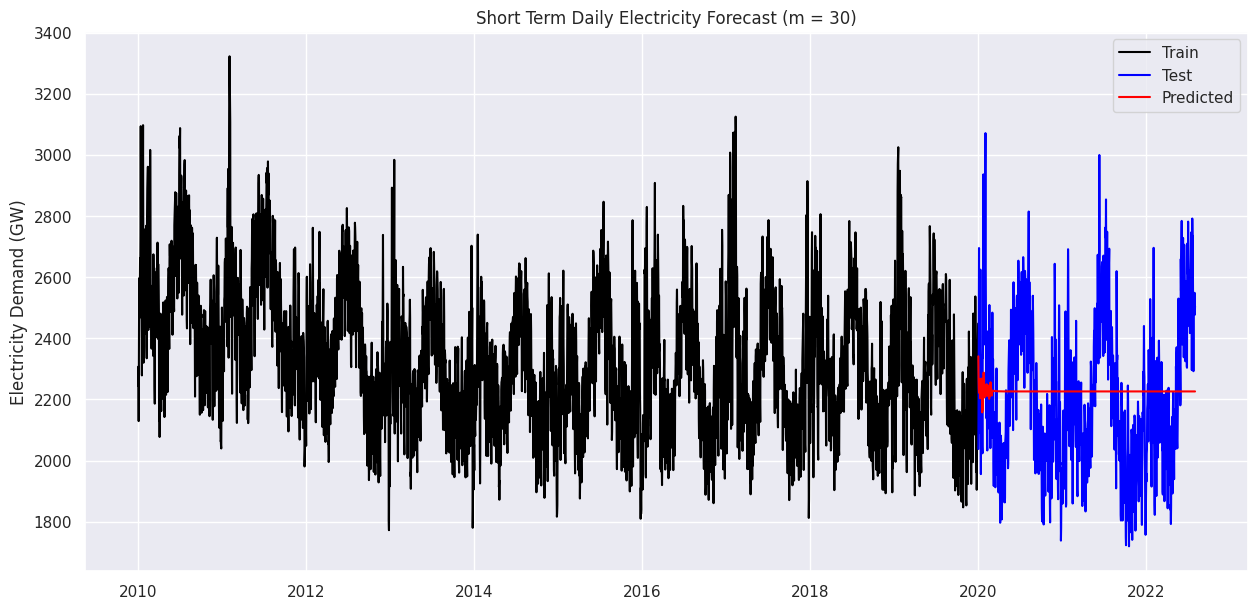

time: 511 ms (started: 2023-04-11 02:55:25 +00:00)


In [506]:
fitted_series_short = pd.Series(short_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_short_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_short_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(fitted_series_short, color = "red", label = "Predicted")
plt.title("Short Term Daily Electricity Forecast (m = 30)")
plt.ylabel("Electricity Demand (GW)")
#plt.xlabel('Time')
plt.legend(loc="best")
sns.set()
plt.show()

#### Medium-term

In [507]:
medium_forecast = medium_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31))

time: 117 ms (started: 2023-04-11 02:55:26 +00:00)


##### Plot Results

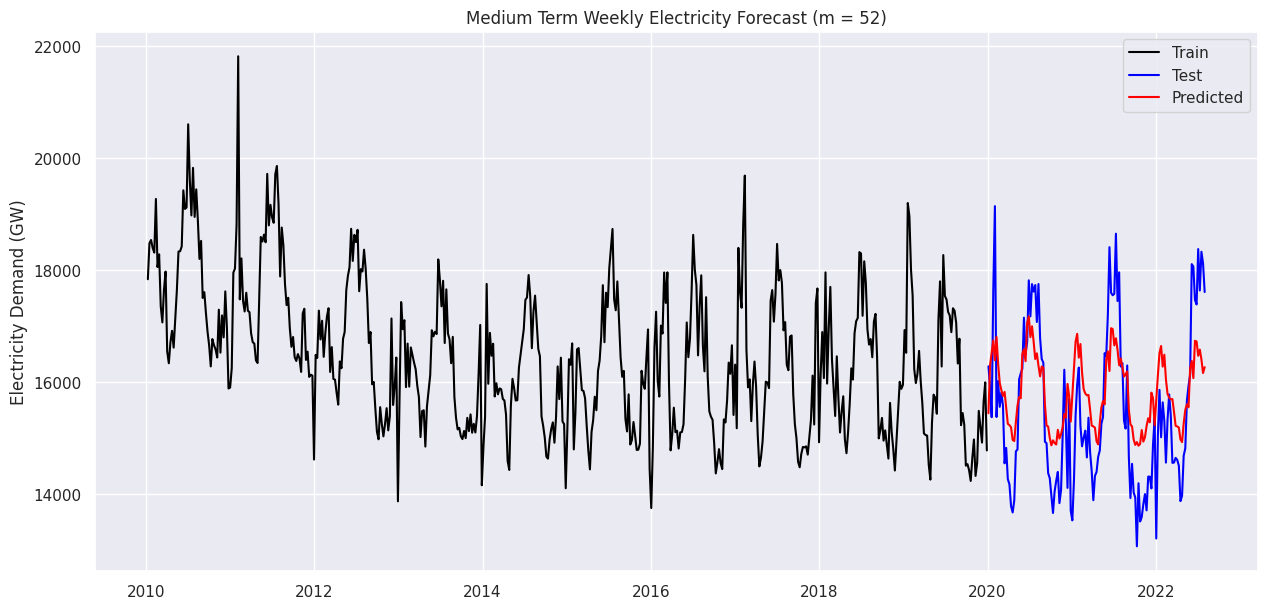

time: 530 ms (started: 2023-04-11 02:55:26 +00:00)


In [508]:
fitted_series_medium = pd.Series(medium_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_medium_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_medium_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(fitted_series_medium, color = "red", label = "Predicted")
plt.title("Medium Term Weekly Electricity Forecast (m = 52)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()

#### Long-term

In [509]:
long_forecast = long_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31))

time: 9.7 ms (started: 2023-04-11 02:55:27 +00:00)


##### Plot Results

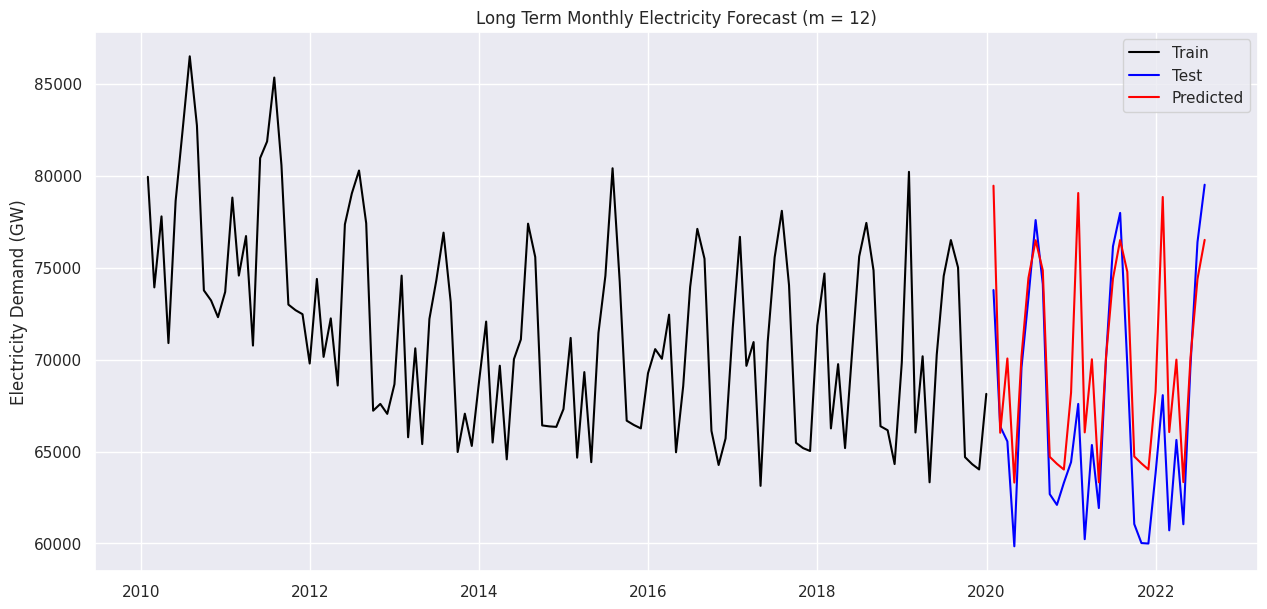

time: 470 ms (started: 2023-04-11 02:55:27 +00:00)


In [510]:
fitted_series_long = pd.Series(long_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_long_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_long_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(fitted_series_long, color = "red", label = "Predicted")
plt.title("Long Term Monthly Electricity Forecast (m = 12)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()

### Performance Metrics

#### Prepare Forecasted and Actual Demand Data

In [511]:
# #short term actual and predicted demand
actual_short = ts_short_test.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
predicted_short_sarima = short_forecast

# #medium term actual and predicted demand
actual_medium = ts_medium_test.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
predicted_medium_sarima = medium_forecast

# #long term actual and predicted demand
actual_long = ts_long_test.drop(['TEMPERATURE','DATE','Month_Number'], axis=1)
predicted_long_sarima = long_forecast

time: 3.01 ms (started: 2023-04-11 02:55:27 +00:00)


#### Short Term Model Performance

In [512]:
mae = mean_absolute_error(actual_short, predicted_short_sarima)
mse = mean_squared_error(actual_short, predicted_short_sarima)
mape = mean_absolute_percentage_error(actual_short, predicted_short_sarima)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 196.1946445861303
Mean Absolute Percentage Error: 0.0891543313334949
Root Mean Squared Error: 237.46580223237817
time: 5.98 ms (started: 2023-04-11 02:55:27 +00:00)


#### Medium Term Model Performance

In [513]:
mae = mean_absolute_error(actual_medium, predicted_medium_sarima)
mse = mean_squared_error(actual_medium, predicted_medium_sarima)
mape = mean_absolute_percentage_error(actual_medium, predicted_medium_sarima)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 889.9732065663444
Mean Absolute Percentage Error: 0.05816018596902702
Root Mean Squared Error: 1054.3116134724094
time: 4.25 ms (started: 2023-04-11 02:55:27 +00:00)


#### Long Term Model Performance

In [514]:
mae = mean_absolute_error(actual_long, predicted_long_sarima)
mse = mean_squared_error(actual_long, predicted_long_sarima)
mape = mean_absolute_percentage_error(actual_long, predicted_long_sarima)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 3310.8034551721694
Mean Absolute Percentage Error: 0.05030820960253041
Root Mean Squared Error: 4258.294527164795
time: 4.39 ms (started: 2023-04-11 02:55:27 +00:00)


## SARIMAX

### Optimal parameters

In [515]:
# Find short-term optimal parameters
# ADF # lags used value as m
# sarima_short_optimal = auto_arima(ts_short['TOTALDEMAND']['2019-01-01':'2022-07-31'],exogenous=ts_short['TEMPERATURE'],seasonal=True,m=30,suppress_warnings=True)
# m=7 as yearly seasonality is assumed on monthly data
# sarima_short_optimal = auto_arima(ts_short['TOTALDEMAND']['2019-01-01':'2022-07-31'],exogenous=ts_short['TEMPERATURE'],seasonal=True,m=7,suppress_warnings=True)
# m=7 as weekly seasonality is assumed on daily data 

# print('Optimal order (short term demand):', sarima_short_optimal.order)
# print('Optimal seasonal_order (short term demand):', sarima_short_optimal.seasonal_order)

time: 227 µs (started: 2023-04-11 02:55:27 +00:00)


In [516]:
# Find medium-term optimal parameters
# ADF # lags used value as m
# sarima_medium_optimal = auto_arima(ts_medium['TOTALDEMAND'],exogenous=ts_medium['TEMPERATURE'],seasonal=True,m=15,suppress_warnings=True)
# m=52 as monthly seasonality is assumed on weekly data
# sarima_medium_optimal = auto_arima(ts_medium['TOTALDEMAND'],exogenous=ts_medium['TEMPERATURE'],seasonal=True,m=52,suppress_warnings=True)

# print('Optimal order (medium term demand):', sarima_medium_optimal.order)
# print('Optimal seasonal_order (medium term demand):', sarima_medium_optimal.seasonal_order)

time: 260 µs (started: 2023-04-11 02:55:27 +00:00)


In [517]:
# Apply differencing to long term demand
ts_long_demand_diff = ts_long.diff().dropna()

time: 1.69 ms (started: 2023-04-11 02:55:27 +00:00)


In [518]:
# Find long-term optimal parameters
# ADF # lags used value as m
# sarima_long_optimal = auto_arima(ts_long_demand_diff['TOTALDEMAND'],exogenous=ts_long_demand_diff['TEMPERATURE'],seasonal=True,m=11,suppress_warnings=True)
# m=12 as yearly seasonality is assumed on monthly data
# sarima_long_optimal = auto_arima(ts_long_demand_diff['TOTALDEMAND'],exogenous=ts_long_demand_diff['TEMPERATURE'],seasonal=True,m=12,suppress_warnings=True)

# print('Optimal order (long term demand):', sarima_long_optimal.order)
# print('Optimal seasonal_order (long term demand):', sarima_long_optimal.seasonal_order)

time: 236 µs (started: 2023-04-11 02:55:27 +00:00)


In [519]:
sarima_short_optimal_order = (1, 1, 4)
sarima_short_optimal_seasonal_order = (0, 0, 2, 30)

sarima_medium_optimal_order = (1, 1, 1)
sarima_medium_optimal_seasonal_order = (1, 0, 2, 52)

sarima_long_optimal_order = (1, 0, 1)
sarima_long_optimal_seasonal_order = (1, 1, 1, 12)

time: 406 µs (started: 2023-04-11 02:55:27 +00:00)


### Summary of optimal paramters:
*   Short-term demand: SARIMA(1,1,4)x(0,0,2,30)
*   Medium-term demand: SARIMA(0,0,1)x(0,0,2,52)
*   Long-term demand: SARIMA(1,0,1)x(1,1,1,12)

### Summary of Train and Test Data

In [520]:
# Short term prediction split:
ts_short_train_x = ts_short['TEMPERATURE'].loc[short_ts_train_dates]
ts_short_train_y = ts_short['TOTALDEMAND'].loc[short_ts_train_dates]
ts_short_test_x = ts_short['TEMPERATURE'].loc[short_ts_test_dates]
ts_short_test_y = ts_short['TOTALDEMAND'].loc[short_ts_test_dates]

# # Medium term prediction split:
ts_medium_train_x = ts_medium['TEMPERATURE'].loc[medium_ts_train_dates]
ts_medium_train_y = ts_medium['TOTALDEMAND'].loc[medium_ts_train_dates]
ts_medium_test_x = ts_medium['TEMPERATURE'].loc[medium_ts_test_dates]
ts_medium_test_y = ts_medium['TOTALDEMAND'].loc[medium_ts_test_dates]

# # Long term prediction split:
ts_long_train_x = ts_long['TEMPERATURE'].loc[long_ts_train_dates]
ts_long_train_y = ts_long['TOTALDEMAND'].loc[long_ts_train_dates]
ts_long_test_x = ts_long['TEMPERATURE'].loc[long_ts_test_dates]
ts_long_test_y = ts_long['TOTALDEMAND'].loc[long_ts_test_dates]

time: 21.6 ms (started: 2023-04-11 02:55:27 +00:00)


### Fit Model on Training Data

#### Short-term demand

In [521]:
short_order = sarima_short_optimal_order
short_seasonal_order = sarima_short_optimal_seasonal_order
short_model = SARIMAX(ts_short_train_y, order = short_order, seasonal_order= short_seasonal_order,exog = ts_short_train_x)
short_model_fit = short_model.fit()

time: 1min 56s (started: 2023-04-11 02:55:27 +00:00)


#### Medium-term demand

In [522]:
medium_order = sarima_medium_optimal_order
medium_seasonal_order = sarima_medium_optimal_seasonal_order
medium_model = SARIMAX(ts_medium_train_y, order = medium_order, seasonal_order= medium_seasonal_order, exog = ts_medium_train_x)
medium_model_fit = medium_model.fit()

time: 44.6 s (started: 2023-04-11 02:57:24 +00:00)


#### Long-term demand

In [523]:
long_order = sarima_long_optimal_order
long_seasonal_order = sarima_long_optimal_seasonal_order
long_model = SARIMAX(ts_long_train_y, order = long_order, seasonal_order= long_seasonal_order, exog = ts_long_train_x)
long_model_fit = long_model.fit()

time: 963 ms (started: 2023-04-11 02:58:08 +00:00)


### Forecast

#### Short-term

In [524]:
short_forecast = short_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31), exog=ts_short_test_x)

time: 135 ms (started: 2023-04-11 02:58:09 +00:00)


##### Plot Results

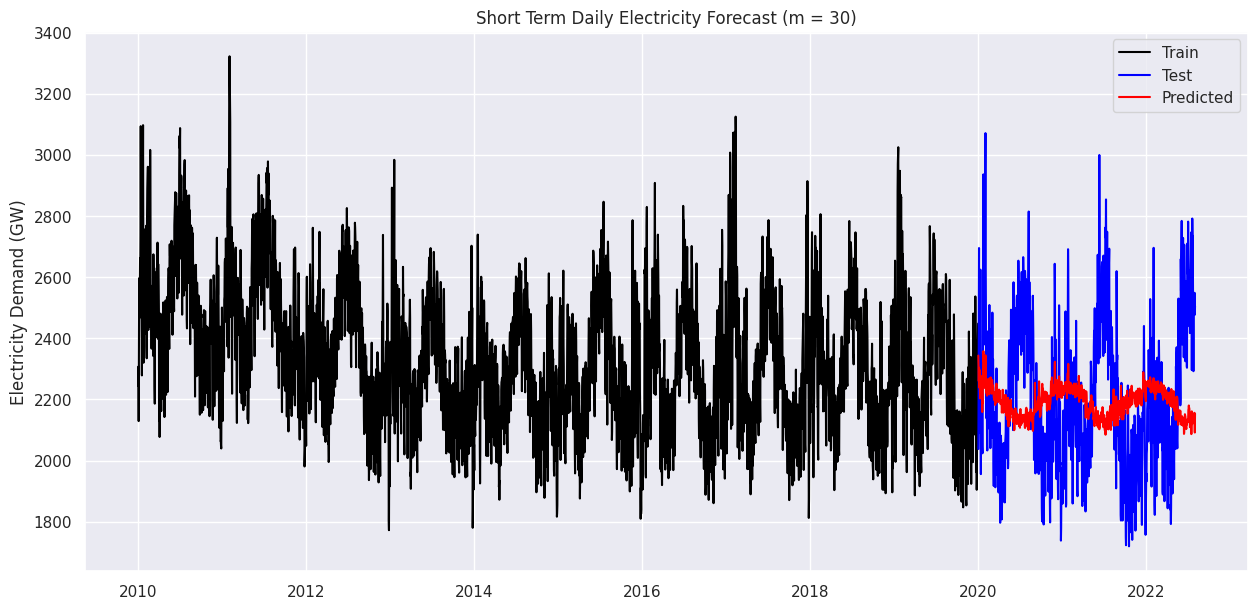

time: 510 ms (started: 2023-04-11 02:58:09 +00:00)


In [525]:
fitted_series_short = pd.Series(short_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_short_train_y, color = "black", label = "Train")
plt.plot(ts_short_test_y, color = "blue", label = "Test")
plt.plot(fitted_series_short, color = "red", label = "Predicted")
plt.title("Short Term Daily Electricity Forecast (m = 30)")
plt.ylabel("Electricity Demand (GW)")
#plt.xlabel('Time')
plt.legend(loc="best")
sns.set()
plt.show()

#### Medium-term

In [526]:
medium_forecast = medium_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31), exog=ts_medium_test_x)

time: 81.7 ms (started: 2023-04-11 02:58:10 +00:00)


##### Plot Results

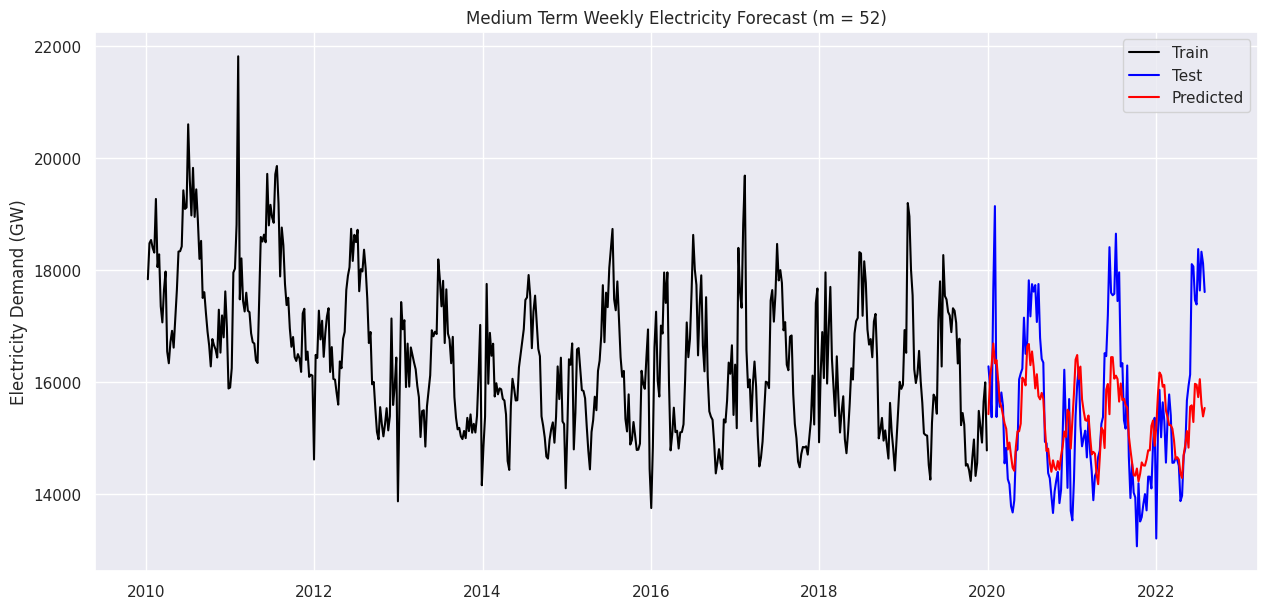

time: 518 ms (started: 2023-04-11 02:58:10 +00:00)


In [527]:
fitted_series_medium = pd.Series(medium_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_medium_train_y, color = "black", label = "Train")
plt.plot(ts_medium_test_y, color = "blue", label = "Test")
plt.plot(fitted_series_medium, color = "red", label = "Predicted")
plt.title("Medium Term Weekly Electricity Forecast (m = 52)")
plt.ylabel("Electricity Demand (GW)")
#plt.xlabel('Time')
plt.legend(loc="best")
sns.set()
plt.show()

#### Long-term

In [528]:
long_forecast = long_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31), exog=ts_long_test_x)

time: 11.6 ms (started: 2023-04-11 02:58:11 +00:00)


##### Plot Results

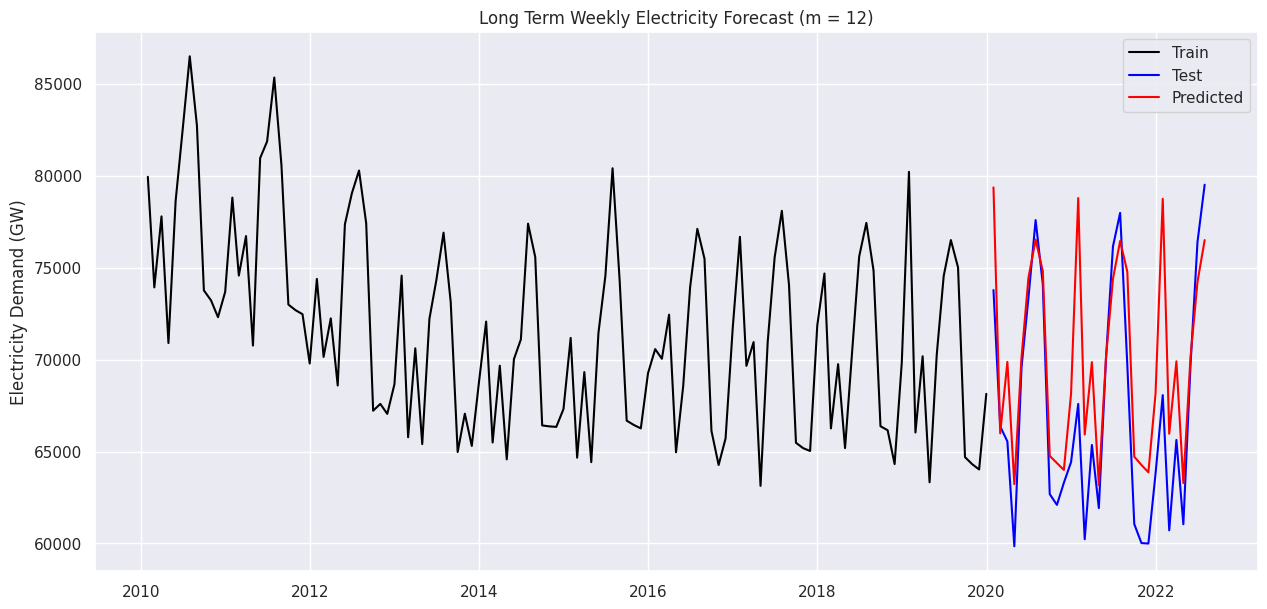

time: 461 ms (started: 2023-04-11 02:58:11 +00:00)


In [529]:
fitted_series_long = pd.Series(long_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_long_train_y, color = "black", label = "Train")
plt.plot(ts_long_test_y, color = "blue", label = "Test")
plt.plot(fitted_series_long, color = "red", label = "Predicted")
plt.title("Long Term Weekly Electricity Forecast (m = 12)")
plt.ylabel("Electricity Demand (GW)")
#plt.xlabel('Time')
plt.legend(loc="best")
sns.set()
plt.show()

### Performance Metrics

#### Prepare Forecasted and Actual Demand Data

In [530]:
#short term actual and predicted demand
actual_short = ts_short_test_y
predicted_short_sarimax = short_forecast

#medium term actual and predicted demand
actual_medium = ts_medium_test_y
predicted_medium_sarimax = medium_forecast

#long term actual and predicted demand
actual_long = ts_long_test_y
predicted_long_sarimax = long_forecast

time: 477 µs (started: 2023-04-11 02:58:11 +00:00)


#### Short Term Model Performance

In [531]:
mae = mean_absolute_error(actual_short, predicted_short_sarimax)
mse = mean_squared_error(actual_short, predicted_short_sarimax)
mape = mean_absolute_percentage_error(actual_short, predicted_short_sarimax)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 208.72914170462616
Mean Absolute Percentage Error: 0.09321777615850774
Root Mean Squared Error: 258.34264159760363
time: 2.93 ms (started: 2023-04-11 02:58:11 +00:00)


#### Medium Term Model Performance

In [532]:
mae = mean_absolute_error(actual_medium, predicted_medium_sarimax)
mse = mean_squared_error(actual_medium, predicted_medium_sarimax)
mape = mean_absolute_percentage_error(actual_medium, predicted_medium_sarimax)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 798.6690812796711
Mean Absolute Percentage Error: 0.04986780683378259
Root Mean Squared Error: 1055.3906322851708
time: 1.99 ms (started: 2023-04-11 02:58:11 +00:00)


#### Long Term Model Performance

In [533]:
mae = mean_absolute_error(actual_long, predicted_long_sarimax)
mse = mean_squared_error(actual_long, predicted_long_sarimax)
mape = mean_absolute_percentage_error(actual_long, predicted_long_sarimax)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 3261.2933498128905
Mean Absolute Percentage Error: 0.04952162284080935
Root Mean Squared Error: 4186.130250117566
time: 2.13 ms (started: 2023-04-11 02:58:11 +00:00)


## Compare SARIMA and SARIMAX

### Short-term (Daily Forecast)

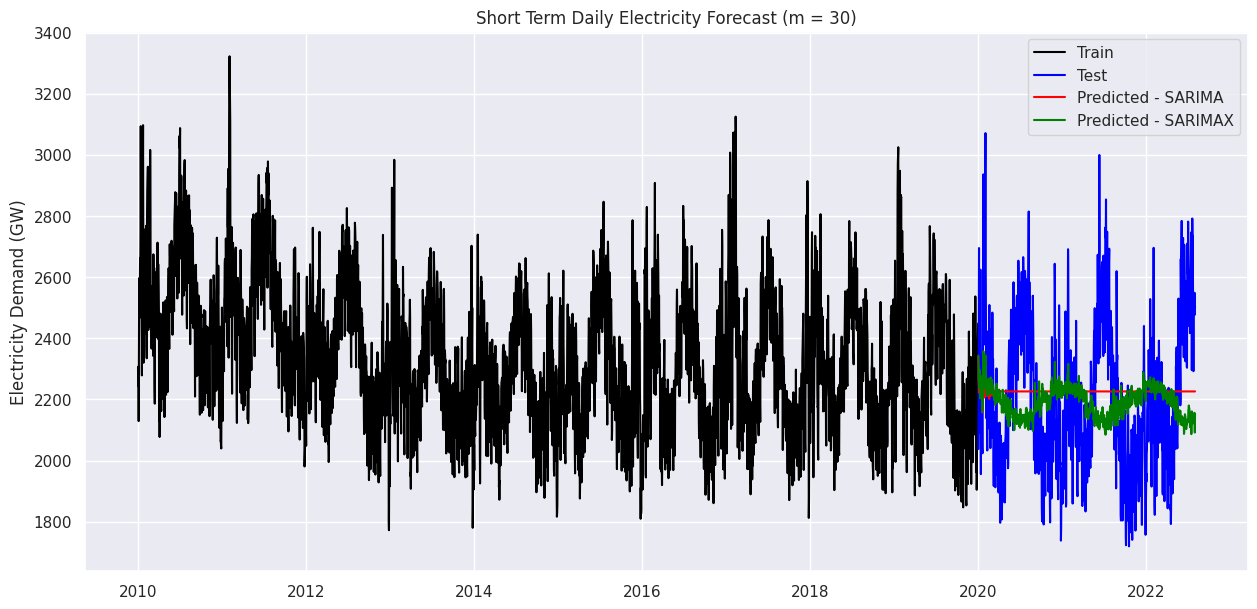

time: 512 ms (started: 2023-04-11 02:58:11 +00:00)


In [534]:
fitted_series_short_sarima = pd.Series(predicted_short_sarima)
fitted_series_short_sarimax = pd.Series(predicted_short_sarimax)
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_short_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_short_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(fitted_series_short_sarima, color = "red", label = "Predicted - SARIMA")
plt.plot(fitted_series_short_sarimax, color = "green", label = "Predicted - SARIMAX")
plt.title("Short Term Daily Electricity Forecast (m = 30)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()

### Medium-term (Weekly Forecast)

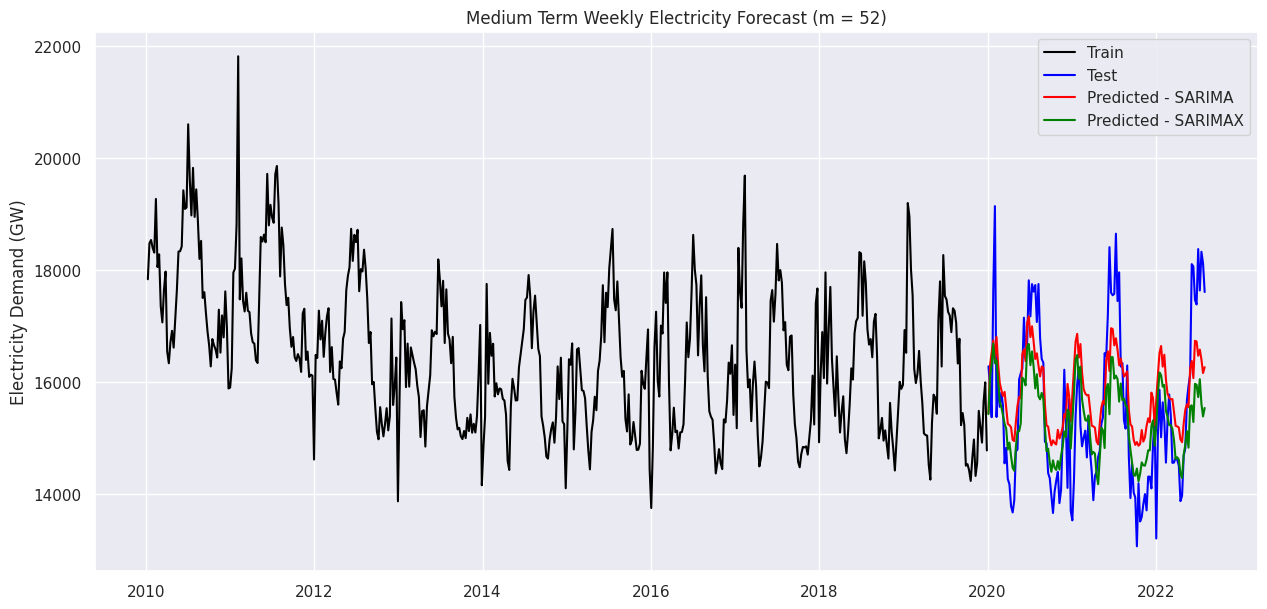

time: 473 ms (started: 2023-04-11 02:58:12 +00:00)


In [535]:
fitted_series_medium_sarima = pd.Series(predicted_medium_sarima)
fitted_series_medium_sarimax = pd.Series(predicted_medium_sarimax)
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_medium_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_medium_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(fitted_series_medium_sarima, color = "red", label = "Predicted - SARIMA")
plt.plot(fitted_series_medium_sarimax, color = "green", label = "Predicted - SARIMAX")
plt.title("Medium Term Weekly Electricity Forecast (m = 52)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()

### Long-term (Monthly Forecast)

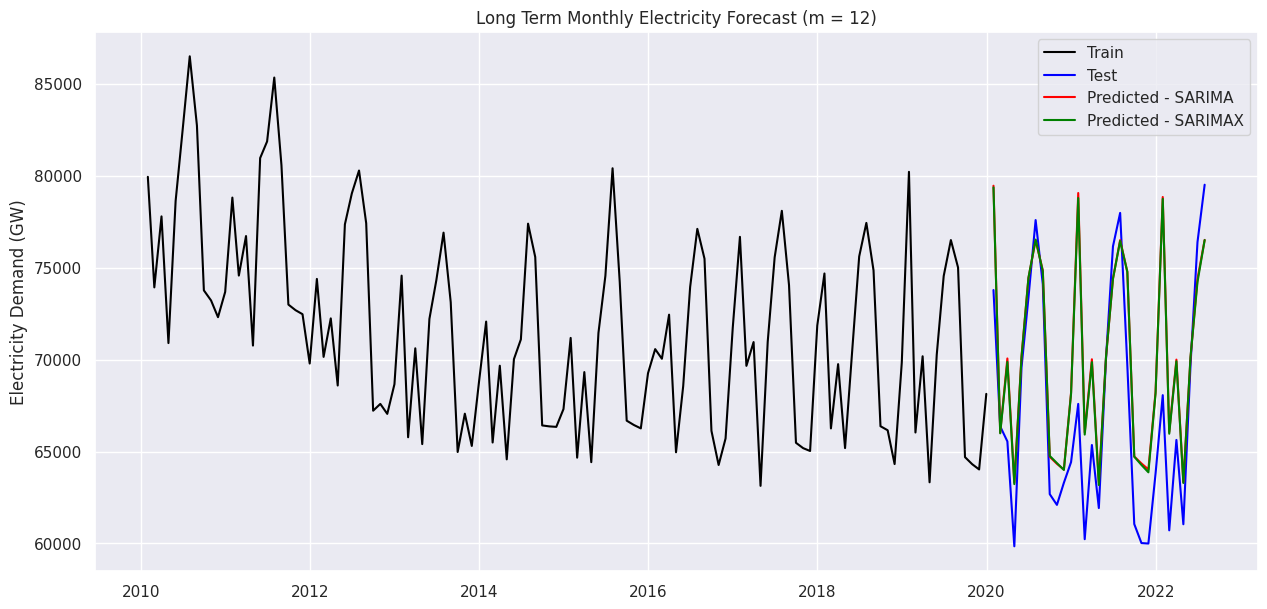

time: 470 ms (started: 2023-04-11 02:58:12 +00:00)


In [536]:
fitted_series_long_sarima = pd.Series(predicted_long_sarima)
fitted_series_long_sarimax = pd.Series(predicted_long_sarimax)
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_long_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_long_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(fitted_series_long_sarima, color = "red", label = "Predicted - SARIMA")
plt.plot(fitted_series_long_sarimax, color = "green", label = "Predicted - SARIMAX")
plt.title("Long Term Monthly Electricity Forecast (m = 12)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()

End of Code

# ELM Model

## Convert to R

In [72]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%reload_ext rpy2.ipython

Found existing installation: rpy2 3.5.5
Uninstalling rpy2-3.5.5:
  Successfully uninstalled rpy2-3.5.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp39-cp39-linux_x86_64.whl size=317891 sha256=a68f59dfb4038a92485414145a6f89f8aed7554765b91a2277b6b91b801bb419
  Stored in directory: /root/.cache/pip/wheels/09/e7/bc/33685b60ab54dba969596dd87244ee9f4c2e83dff9a53d4f20
Successfully built rpy2
time: 13.8 s (started: 2023-04-10 23:31:23 +00:00)


In [ ]:
%%R
#for data processing 
library(tidyverse)
#for EDA
install.packages("GGally")

library(GGally)
library(ggplot2)
#for ELM&regression
install.packages("elmNNRcpp")
install.packages("corrplot")
install.packages("glmnet")
install.packages("caret")
install.packages("ELMR")
library(elmNNRcpp)
library(KernelKnn)
library(corrplot)
library(glmnet)
library(caret)
library(ELMR)

## Fit Model on Training Data - ELM

### Short-term demand

In [537]:
%%R -i ts_short_train -i ts_short_test
# fitting elm model using short-term data
elm_short_train_x<-as.matrix(cbind(ts_short_train[,'TEMPERATURE'],ts_short_train[,'DATE']))
elm_short_train_y<-as.matrix(ts_short_train[,'TOTALDEMAND'])
elm_short_test_x<-as.matrix(cbind(ts_short_test[,'TEMPERATURE'],ts_short_test[,'DATE']))
elm_short_test_y<-as.matrix(ts_short_test[,'TOTALDEMAND'])
elm_short_model<-elm_train(elm_short_train_x,elm_short_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_short_predict_y = elm_predict(elm_short_model,elm_short_test_x)
# results
data.frame(mae=mean(abs(elm_short_predict_y-elm_short_test_y)),mape=mean(abs(elm_short_predict_y-elm_short_test_y)/elm_short_test_y), rmse=sqrt(mean((elm_short_predict_y-elm_short_test_y)^2)))

       mae     mape     rmse
1 233.9955 0.110995 274.5846
time: 186 ms (started: 2023-04-11 03:04:04 +00:00)


### Medium-term demand

In [538]:
%%R -i ts_medium_train -i ts_medium_test
# fitting elm model using short-term data
elm_medium_train_x<-as.matrix(cbind(ts_medium_train[,'TEMPERATURE'],ts_medium_train[,'DATE']))
elm_medium_train_y<-as.matrix(ts_medium_train[,'TOTALDEMAND'])
elm_medium_test_x<-as.matrix(cbind(ts_medium_test[,'TEMPERATURE'],ts_medium_test[,'DATE']))
elm_medium_test_y<-as.matrix(ts_medium_test[,'TOTALDEMAND'])
elm_medium_model<-elm_train(elm_medium_train_x,elm_medium_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_medium_predict_y = elm_predict(elm_medium_model,elm_medium_test_x)
# results
data.frame(mae=mean(abs(elm_medium_predict_y-elm_medium_test_y)),mape=mean(abs(elm_medium_predict_y-elm_medium_test_y)/elm_medium_test_y), rmse=sqrt(mean((elm_medium_predict_y-elm_medium_test_y)^2)))

       mae      mape     rmse
1 1505.829 0.1009737 1712.267
time: 57.7 ms (started: 2023-04-11 03:04:05 +00:00)


### Long-term demand

In [539]:
%%R -i ts_long_train -i ts_long_test
# fitting elm model using short-term data
elm_long_train_x<-as.matrix(cbind(ts_long_train[,'TEMPERATURE'],ts_long_train[,'DATE']))
elm_long_train_y<-as.matrix(ts_long_train[,'TOTALDEMAND'])
elm_long_test_x<-as.matrix(cbind(ts_long_test[,'TEMPERATURE'],ts_long_test[,'DATE']))
elm_long_test_y<-as.matrix(ts_long_test[,'TOTALDEMAND'])
elm_long_model<-elm_train(elm_long_train_x,elm_long_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_long_predict_y = elm_predict(elm_long_model,elm_long_test_x)
# results
data.frame(mae=mean(abs(elm_long_predict_y-elm_long_test_y)),mape=mean(abs(elm_long_predict_y-elm_long_test_y)/elm_long_test_y), rmse=sqrt(mean((elm_long_predict_y-elm_long_test_y)^2)))

       mae      mape     rmse
1 6573.305 0.1015944 7390.977
time: 60.4 ms (started: 2023-04-11 03:04:05 +00:00)


## Plot Result

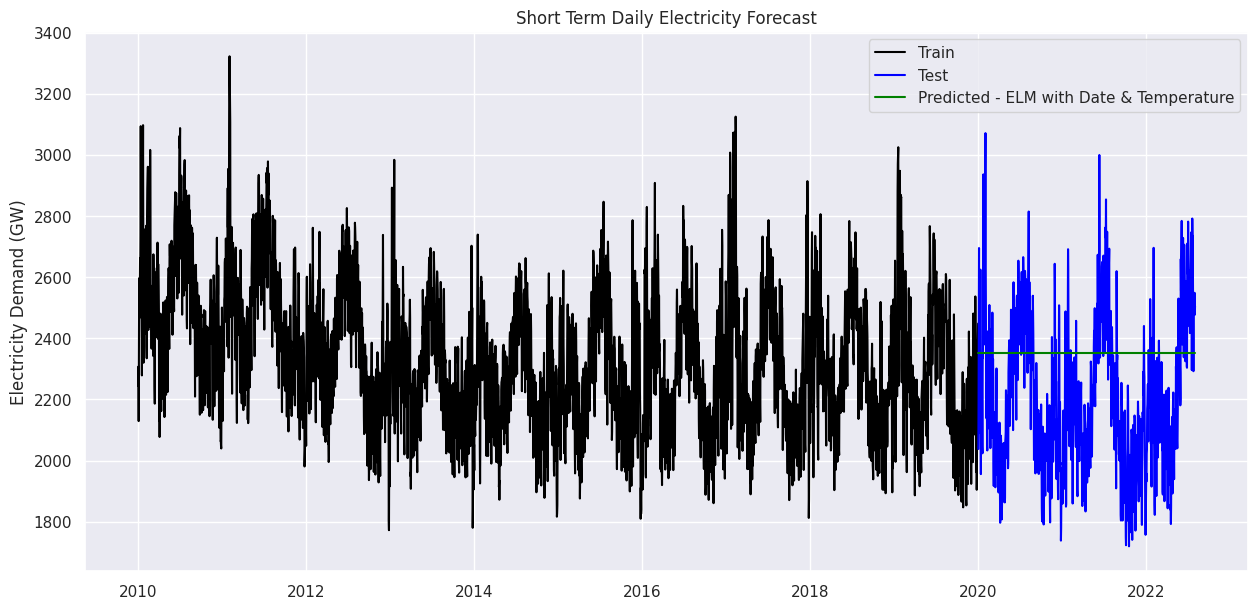

<Figure size 640x480 with 0 Axes>

time: 527 ms (started: 2023-04-11 03:04:09 +00:00)


In [540]:
# Plot Result
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_short_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_short_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_short_test['DATE'], elm_short_predict_y,  color = "green", label = "Predicted - ELM with Date & Temperature")
plt.title("Short Term Daily Electricity Forecast")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()

In [541]:
%%R -i ts_medium_train -i ts_medium_test
# fitting elm model using medium-term data
elm_medium_train_x<-as.matrix(cbind(ts_medium_train[,'TEMPERATURE'],ts_medium_train[,'DATE']))
elm_medium_train_y<-as.matrix(ts_medium_train[,'TOTALDEMAND'])
elm_medium_test_x<-as.matrix(cbind(ts_medium_test[,'TEMPERATURE'],ts_medium_test[,'DATE']))
elm_medium_test_y<-as.matrix(ts_medium_test[,'TOTALDEMAND'])
elm_medium_model<-elm_train(elm_medium_train_x,elm_medium_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_medium_predict_y = elm_predict(elm_medium_model,elm_medium_test_x)
# results
data.frame(mae=mean(abs(elm_medium_predict_y-elm_medium_test_y)),mape=mean(abs(elm_medium_predict_y-elm_medium_test_y)/elm_medium_test_y), rmse=sqrt(mean((elm_medium_predict_y-elm_medium_test_y)^2)))

       mae      mape     rmse
1 1505.829 0.1009737 1712.267
time: 62.9 ms (started: 2023-04-11 03:04:10 +00:00)


In [542]:
%%R -i ts_long_train -i ts_long_test
# fitting elm model using long-term data
elm_long_train_x<-as.matrix(cbind(ts_long_train[,'TEMPERATURE'],ts_long_train[,'DATE']))
elm_long_train_y<-as.matrix(ts_long_train[,'TOTALDEMAND'])
elm_long_test_x<-as.matrix(cbind(ts_long_test[,'TEMPERATURE'], ts_long_test[,'DATE']))
elm_long_test_y<-as.matrix(ts_long_test[,'TOTALDEMAND'])
elm_long_model<-elm_train(elm_long_train_x,elm_long_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_long_predict_y = elm_predict(elm_long_model,elm_long_test_x)
# results
data.frame(mae=mean(abs(elm_long_predict_y-elm_long_test_y)),mape=mean(abs(elm_long_predict_y-elm_long_test_y)/elm_long_test_y), rmse=sqrt(mean((elm_long_predict_y-elm_long_test_y)^2)))


       mae      mape     rmse
1 6573.305 0.1015944 7390.977
time: 88.7 ms (started: 2023-04-11 03:04:10 +00:00)


## Fit Model on Training Data - ELM with Temperature & Month Number

### Short-term demand

In [543]:
%%R -i ts_short_train -i ts_short_test
# fitting elm model using short-term data
elm_short_train_x3<-as.matrix(cbind(ts_short_train[,'TEMPERATURE'],ts_short_train[,'Month_Number']))
elm_short_train_y<-as.matrix(ts_short_train[,'TOTALDEMAND'])
elm_short_test_x3<-as.matrix(cbind(ts_short_test[,'TEMPERATURE'],ts_short_test[,'Month_Number']))
elm_short_test_y<-as.matrix(ts_short_test[,'TOTALDEMAND'])
elm_short_model3<-elm_train(elm_short_train_x3,elm_short_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_short_predict_y3 = elm_predict(elm_short_model3,elm_short_test_x3)
# results
data.frame(mae=mean(abs(elm_short_predict_y3-elm_short_test_y)),mape=mean(abs(elm_short_predict_y3-elm_short_test_y)/elm_short_test_y), rmse=sqrt(mean((elm_short_predict_y3-elm_short_test_y)^2)))

       mae      mape     rmse
1 168.6973 0.0803876 203.4516
time: 169 ms (started: 2023-04-11 03:04:12 +00:00)


### Medium-term demand

In [544]:
%%R -i ts_medium_train -i ts_medium_test
# fitting elm model using short-term data
elm_medium_train_x3<-as.matrix(cbind(ts_medium_train[,'TEMPERATURE'],ts_medium_train[,'Month_Number']))
elm_medium_train_y<-as.matrix(ts_medium_train[,'TOTALDEMAND'])
elm_medium_test_x3<-as.matrix(cbind(ts_medium_test[,'TEMPERATURE'],ts_medium_test[,'Month_Number']))
elm_medium_test_y<-as.matrix(ts_medium_test[,'TOTALDEMAND'])
elm_medium_model3<-elm_train(elm_medium_train_x3,elm_medium_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_medium_predict_y3 = elm_predict(elm_medium_model3,elm_medium_test_x3)
# results
data.frame(mae=mean(abs(elm_medium_predict_y3-elm_medium_test_y)),mape=mean(abs(elm_medium_predict_y3-elm_medium_test_y)/elm_medium_test_y), rmse=sqrt(mean((elm_medium_predict_y3-elm_medium_test_y)^2)))

       mae       mape     rmse
1 1008.783 0.06784392 1167.043
time: 64.9 ms (started: 2023-04-11 03:04:13 +00:00)


### Long-term demand

In [545]:
%%R -i ts_long_train -i ts_long_test
# fitting elm model using short-term data
elm_long_train_x3<-as.matrix(cbind(ts_long_train[,'TEMPERATURE'],ts_long_train[,'Month_Number']))
elm_long_train_y<-as.matrix(ts_long_train[,'TOTALDEMAND'])
elm_long_test_x3<-as.matrix(cbind(ts_long_test[,'TEMPERATURE'],ts_long_test[,'Month_Number']))
elm_long_test_y<-as.matrix(ts_long_test[,'TOTALDEMAND'])
elm_long_model3<-elm_train(elm_long_train_x3,elm_long_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
# prediction
elm_long_predict_y3 = elm_predict(elm_long_model3,elm_long_test_x3)
# results
data.frame(mae=mean(abs(elm_long_predict_y3-elm_long_test_y)),mape=mean(abs(elm_long_predict_y3-elm_long_test_y)/elm_long_test_y), rmse=sqrt(mean((elm_long_predict_y3-elm_long_test_y)^2)))

       mae       mape     rmse
1 4514.774 0.06932028 5047.531
time: 43.3 ms (started: 2023-04-11 03:04:13 +00:00)


## Fit Model on Training Data - ELM with Temperature Only

In [546]:
%%R
# fitting elm model using short-term data dropping date
elm_short_train_x2<-as.matrix(cbind(ts_short_train[,'TEMPERATURE']))
elm_short_test_x2<-as.matrix(cbind(ts_short_test[,'TEMPERATURE']))
elm_short_model2<-elm_train(elm_short_train_x2,elm_short_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
elm_short_predict_y2 = elm_predict(elm_short_model2,elm_short_test_x2)
data.frame(mae=mean(abs(elm_short_predict_y2-elm_short_test_y)), mape=mean(abs(elm_short_predict_y2-elm_short_test_y)/elm_short_test_y), rmse=sqrt(mean((elm_short_predict_y2-elm_short_test_y)^2)))

       mae       mape     rmse
1 175.4114 0.08363186 212.5599
time: 45.1 ms (started: 2023-04-11 03:04:16 +00:00)


In [547]:
%%R 
# fitting elm model using medium-term data dropping date
elm_medium_train_x2<-as.matrix(cbind(ts_medium_train[,'TEMPERATURE']))
elm_medium_test_x2<-as.matrix(cbind(ts_medium_test[,'TEMPERATURE']))

elm_medium_model2<-elm_train(elm_medium_train_x2,elm_medium_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
elm_medium_predict_y2 = elm_predict(elm_medium_model2,elm_medium_test_x2)
data.frame(mae=mean(abs(elm_medium_predict_y2-elm_medium_test_y)),mape=mean(abs(elm_medium_predict_y2-elm_medium_test_y)/elm_medium_test_y), rmse=sqrt(mean((elm_medium_predict_y2-elm_medium_test_y)^2)))

       mae       mape     rmse
1 985.9787 0.06666132 1160.009
time: 28.3 ms (started: 2023-04-11 03:04:17 +00:00)


In [548]:
%%R 
# fitting elm model using long-term data dropping date
elm_long_train_x2<-as.matrix(cbind(ts_long_train[,'TEMPERATURE']))
elm_long_test_x2<-as.matrix(cbind(ts_long_test[,'TEMPERATURE']))

elm_long_model2<-elm_train(elm_long_train_x2,elm_long_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
elm_long_predict_y2 = elm_predict(elm_long_model2,elm_long_test_x2)
data.frame(mae=mean(abs(elm_long_predict_y2-elm_long_test_y)),mape=mean(abs(elm_long_predict_y2-elm_long_test_y)/elm_long_test_y), rmse=sqrt(mean((elm_long_predict_y2-elm_long_test_y)^2)))

       mae       mape     rmse
1 4155.965 0.06457552 4857.827
time: 40.9 ms (started: 2023-04-11 03:04:17 +00:00)


## Plot result

In [549]:
%R -o elm_short_predict_y -o elm_short_predict_y2 -o elm_short_predict_y3 -o elm_medium_predict_y -o elm_medium_predict_y2 -o elm_medium_predict_y3 -o elm_long_predict_y -o elm_long_predict_y2 -o elm_long_predict_y3


time: 7.78 ms (started: 2023-04-11 03:04:31 +00:00)


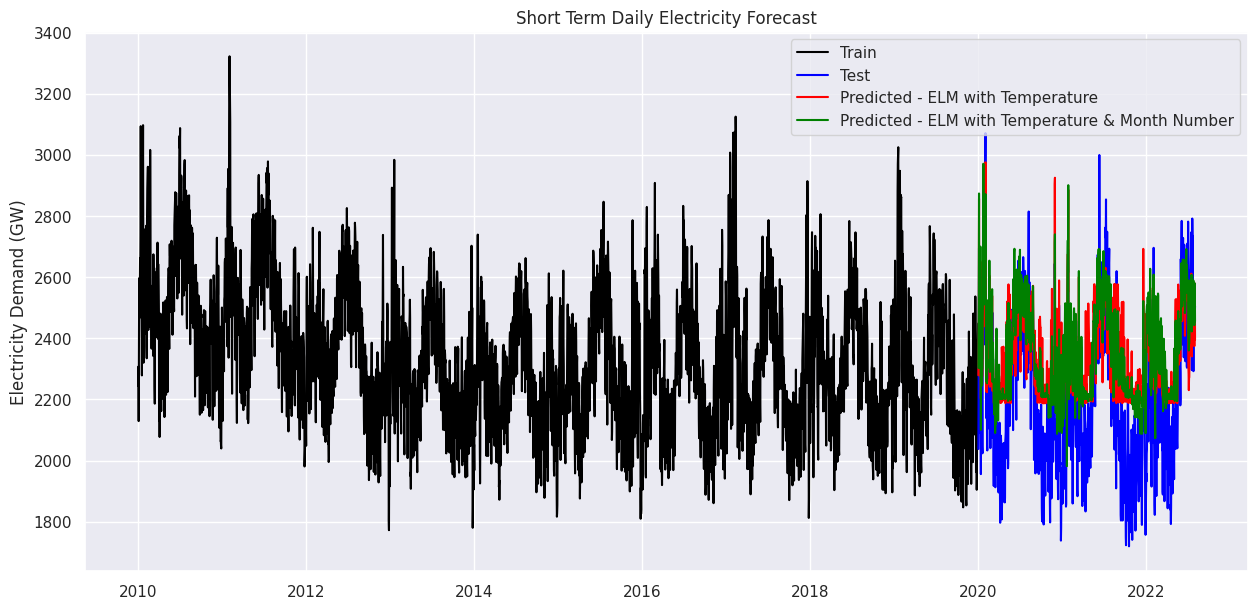

<Figure size 640x480 with 0 Axes>

time: 592 ms (started: 2023-04-11 03:04:32 +00:00)


In [550]:
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_short_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_short_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_short_test['DATE'], elm_short_predict_y2,  color = "red", label = "Predicted - ELM with Temperature")
plt.plot(ts_short_test['DATE'], elm_short_predict_y3,  color = "green", label = "Predicted - ELM with Temperature & Month Number")
plt.title("Short Term Daily Electricity Forecast")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()

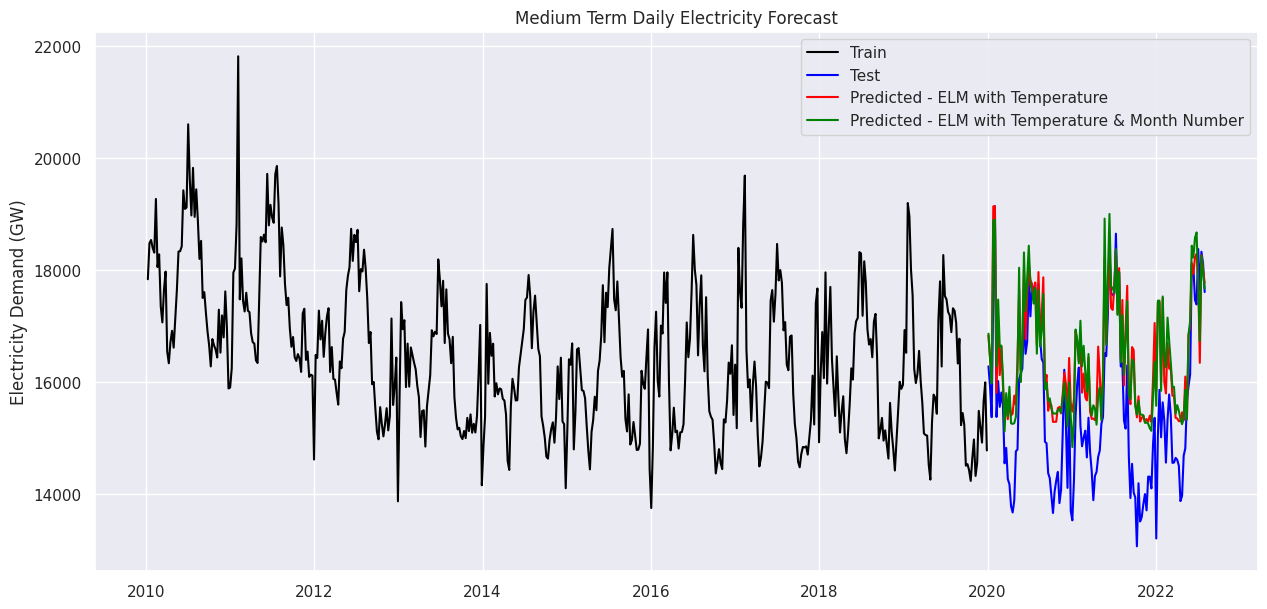

<Figure size 640x480 with 0 Axes>

time: 498 ms (started: 2023-04-11 03:04:32 +00:00)


In [551]:
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_medium_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_medium_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_medium_test['DATE'], elm_medium_predict_y2,  color = "red", label = "Predicted - ELM with Temperature")
plt.plot(ts_medium_test['DATE'], elm_medium_predict_y3,  color = "green", label = "Predicted - ELM with Temperature & Month Number")
plt.title("Medium Term Daily Electricity Forecast")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()

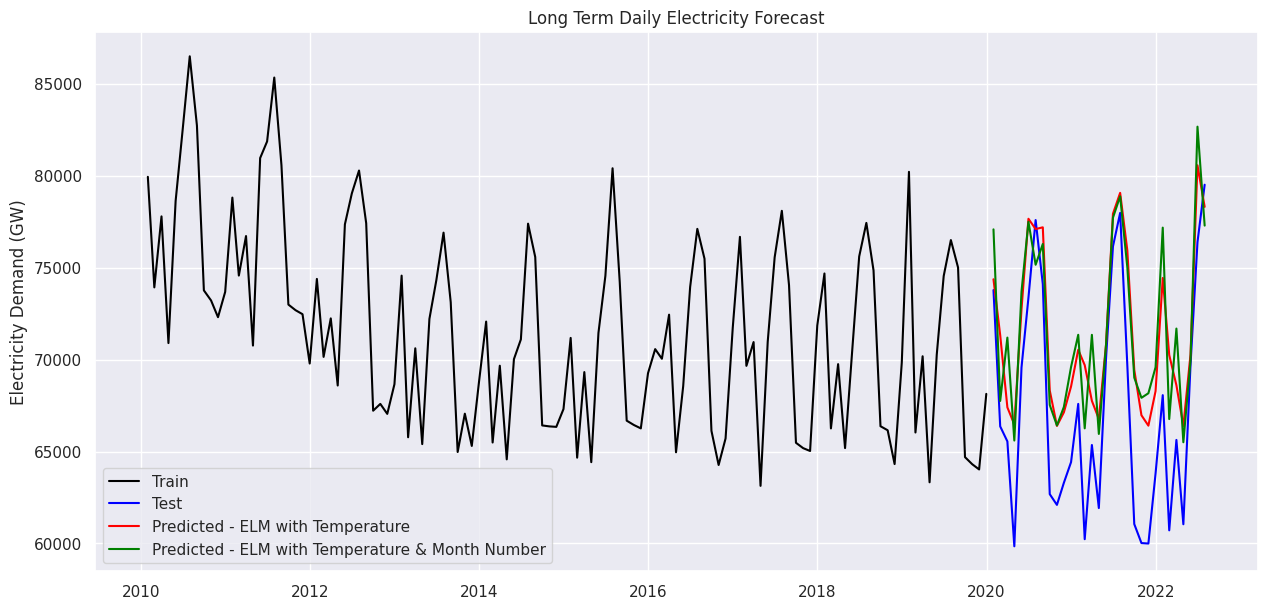

<Figure size 640x480 with 0 Axes>

time: 516 ms (started: 2023-04-11 03:04:33 +00:00)


In [552]:
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_long_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_long_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_long_test['DATE'], elm_long_predict_y2, color = "red", label = "Predicted - ELM with Temperature")
plt.plot(ts_long_test['DATE'], elm_long_predict_y3, color = "green", label = "Predicted - ELM with Temperature & Month Number")
plt.title("Long Term Daily Electricity Forecast")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()

time: 523 ms (started: 2023-04-11 03:04:33 +00:00)


## Remodel with K-fold Cross Validation

In [553]:
%%R -i ts_short -i ts_medium -i ts_long

# create function for elm models

elm_model<-function(X_train, Y_train, X_test){
  elm <- elm_train(X_train, Y_train,nhid=50,actfun='sig',init_weights='normal_gaussian')
  Y_pred <- elm_predict(elm,X_test)
  return(Y_pred)
}

k_fold_cv <- function(data, k) {
  mse <- rep(0, k)  
  
  for(i in 1:k) {
    # split data
    folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
    validation.index <- which(folds == i, arr.ind = TRUE)
    validation.data <- data[validation.index, ]
    train.data <- data[-validation.index, ]
    
    Y_pred <- elm_model(as.matrix(train.data[, 'TEMPERATURE']), as.matrix(train.data[, 'TOTALDEMAND']), 
                        as.matrix(validation.data[, 'TEMPERATURE']))
    
    mse[i] <- sum((Y_pred - validation.data[, 'TOTALDEMAND'])^2) / length(Y_pred)
  }
  
  cv_error <- mean(mse)  
  cv_mae <- mean(abs(Y_pred-validation.data[, 'TOTALDEMAND']))
  cv_rmse <- sqrt(cv_error)
  cv_mape <- mean(abs(Y_pred-validation.data[, 'TOTALDEMAND'])/validation.data[, 'TOTALDEMAND'])
  data.frame(mae = cv_mae, mape=cv_mape, rmse=cv_rmse)
}


time: 135 ms (started: 2023-04-11 03:04:56 +00:00)


In [554]:
%%R
k_fold_cv(ts_short, 680)

       mae       mape     rmse
1 79.69969 0.03173102 184.6861
time: 26.1 s (started: 2023-04-11 03:04:56 +00:00)


In [555]:
%%R
k_fold_cv(ts_medium, 400)

       mae        mape     rmse
1 118.4099 0.006588045 876.9492
time: 8.52 s (started: 2023-04-11 03:05:23 +00:00)


In [556]:
%%R
k_fold_cv(ts_long, 150)

       mae       mape     rmse
1 1651.718 0.02077408 3664.636
time: 2.65 s (started: 2023-04-11 03:05:31 +00:00)


# Final Comparison Charts

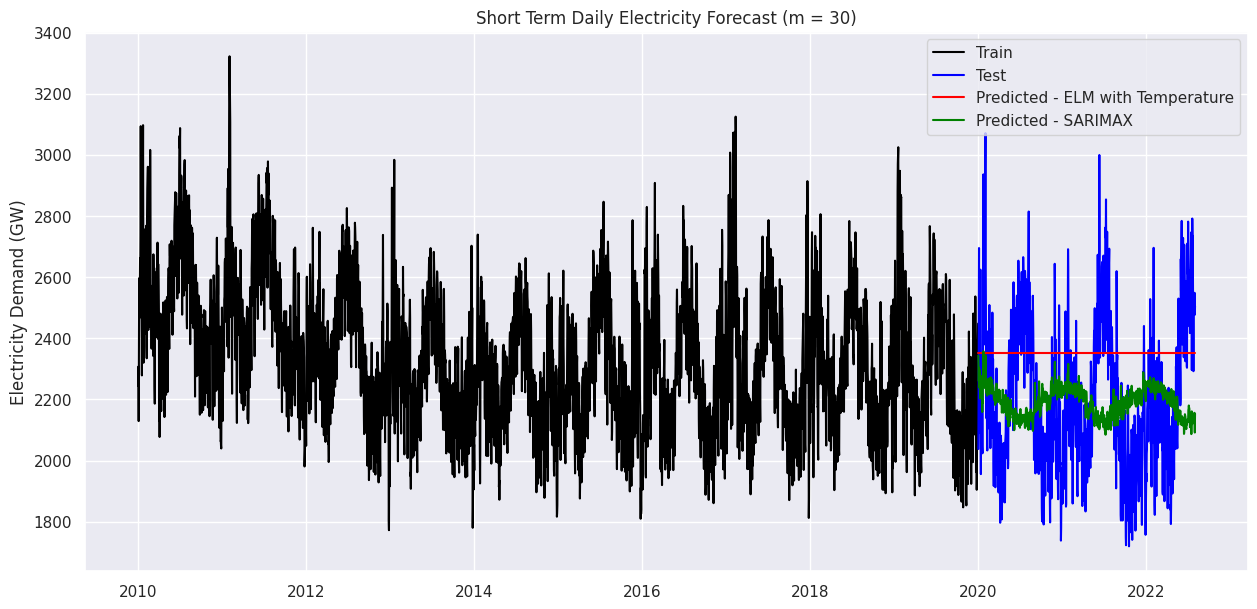

<Figure size 640x480 with 0 Axes>

time: 551 ms (started: 2023-04-11 03:08:31 +00:00)


In [557]:
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_short_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_short_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_short_test['DATE'], elm_short_predict_y, color = "red", label = "Predicted - ELM with Temperature")
plt.plot(fitted_series_short_sarimax, color = "green", label = "Predicted - SARIMAX")
plt.title("Short Term Daily Electricity Forecast (m = 30)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()

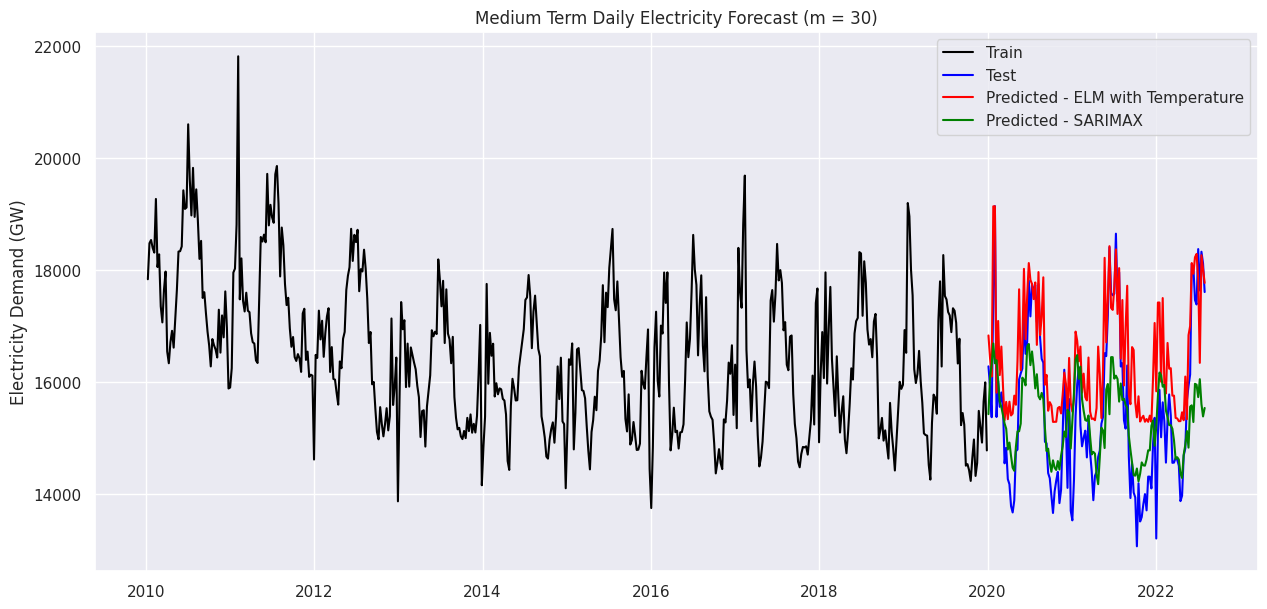

<Figure size 640x480 with 0 Axes>

time: 480 ms (started: 2023-04-11 03:08:32 +00:00)


In [558]:
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_medium_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_medium_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_medium_test['DATE'], elm_medium_predict_y2, color = "red", label = "Predicted - ELM with Temperature")
plt.plot(fitted_series_medium_sarimax, color = "green", label = "Predicted - SARIMAX")
plt.title("Medium Term Daily Electricity Forecast (m = 30)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()

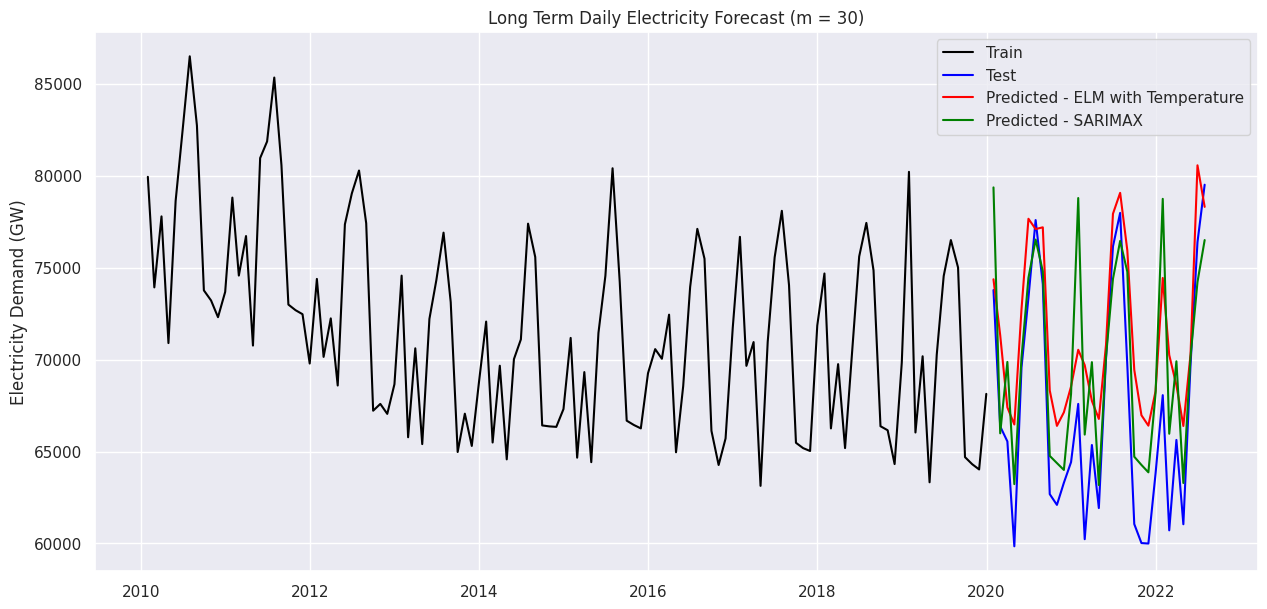

<Figure size 640x480 with 0 Axes>

time: 616 ms (started: 2023-04-11 03:08:33 +00:00)


In [559]:
plt.figure(figsize=(15,7))
plt.plot(ts_sarima_long_train["TOTALDEMAND"], color = "black", label = "Train")
plt.plot(ts_sarima_long_test["TOTALDEMAND"], color = "blue", label = "Test")
plt.plot(ts_long_test['DATE'], elm_long_predict_y2, color = "red", label = "Predicted - ELM with Temperature")
plt.plot(fitted_series_long_sarimax, color = "green", label = "Predicted - SARIMAX")
plt.title("Long Term Daily Electricity Forecast (m = 30)")
plt.ylabel("Electricity Demand (GW)")
plt.legend(loc="best")
sns.set()
plt.show()
plt.clf()